In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval

# Data Importing and Exploration

In [210]:
movies = pd.read_csv('movies_metadata.csv', low_memory=False)
ratings = pd.read_csv('ratings.csv')
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')
links = pd.read_csv('links.csv')

In [82]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


# Popularity based recommender

Using IMDB's weighted rating(wr) to rate a movie:

wr = ((v/(v+m))*R)+((m/v+m)*C)

v - no: of votes for the movie, 
m - minimum votes required to be listed in the chart,
R - average rating of the movie,
C - mean vote across the whole report,


For a movie to feature in the charts, it must have more than atleast 90% of the movies in the list, so we will use 90th percentile as the cut off

In [152]:
m=movies['vote_count'].quantile(0.9)
m

156.0

In [153]:
q_movies = movies.copy().loc[movies['vote_count']>=m]
q_movies.shape

(4680, 30)

There are 4680 movies that qualify to be in the list

Calculating weighted rating

In [154]:
def wr(x,m=m,C=C):
    v=x['vote_count']
    R=x['vote_average']
    return(v/(v+m)*R) + (m/(m+v)*C)

In [155]:
q_movies['score'] = q_movies.apply(wr,axis=1)

Sorting movies based on the score calculated above

In [156]:
q_movies = q_movies.sort_values('score', ascending=False)

The top 15 movies

In [157]:
q_movies[['title','vote_count','vote_average','score']].head(10)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.447079
10397,Dilwale Dulhania Le Jayenge,661.0,9.1,8.433941
841,The Godfather,6024.0,8.5,8.427092
12589,The Dark Knight,12269.0,8.3,8.266248
2870,Fight Club,9678.0,8.3,8.257355
292,Pulp Fiction,8670.0,8.3,8.252485
522,Schindler's List,4436.0,8.3,8.208674
23868,Whiplash,4376.0,8.3,8.207465
5529,Spirited Away,3968.0,8.3,8.198310
2231,Life Is Beautiful,3643.0,8.3,8.189610


Text(0.5, 1.0, 'Popular Movies')

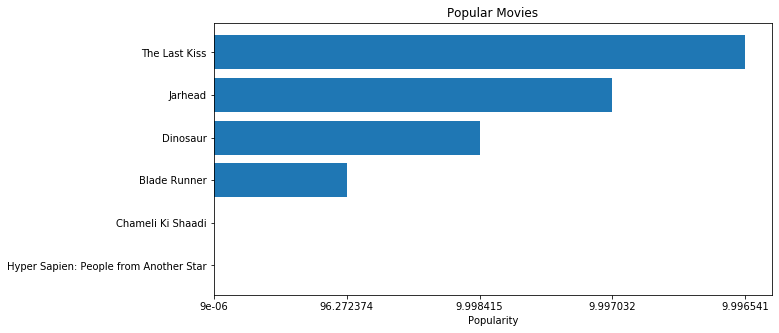

In [168]:
pop = movies.sort_values('popularity', ascending=False)
plt.figure(figsize=(10,5))
plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center')
plt.xlabel('Popularity')
plt.title('Popular Movies')


# Content based Recommender

In [127]:
movies['overview'].head(5)

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

Removing all english stop words('the','a')

In [83]:
tfid = TfidfVectorizer(stop_words='english')

Replacing NaN with an empty string

In [169]:
movies.overview=movies.overview.fillna('')

Constructing the TF-IDF matrix

In [170]:
tfid_matrix=tfid.fit_transform(movies.overview)

In [171]:
tfid_matrix.shape

(46628, 75827)

Over 75000 different words are used to describe the 46628 movies

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate.

In [172]:
cos_sim=cosine_similarity(tfid_matrix,tfid_matrix)

Building a reverse map of indices and movie titles

In [132]:
indices=pd.Series(movies.index, index=movies['title']).drop_duplicates()
indices.head()

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64

Defining a function that takes in movie title and outputs the most similar movies

In [181]:
def recommend_engine(title,cos_sim=cos_sim):
# Get the index of the movie given its title.
    ind=indices[title]
# Get the list of cosine similarity scores for that particular movie with all movies
    sim_movies=list(enumerate(cos_sim[ind]))
# Sort the movies based on the similarity scores
    sim_movies=sorted(sim_movies, key=lambda x: x[1], reverse=True)
# Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
    sim_movies=sim_movies[1:11]
# Get the movie indices
    sim_num=[x[0] for x in sim_movies]
# Return the top 10 similar movies
    return movies['title'].iloc[sim_num]
    


In [182]:
recommend_engine('The Dark Knight Rises')

12589                                      The Dark Knight
150                                         Batman Forever
1349                                        Batman Returns
15682                           Batman: Under the Red Hood
585                                                 Batman
21393    Batman Unmasked: The Psychology of the Dark Kn...
9312                    Batman Beyond: Return of the Joker
18225                                     Batman: Year One
19981              Batman: The Dark Knight Returns, Part 1
3122                          Batman: Mask of the Phantasm
Name: title, dtype: object

In [211]:
movies = movies.drop([19730, 29503, 35587])

keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies['id'] = movies['id'].astype('int')

movies = movies.merge(keywords, on='id')
movies = movies.merge(credits, on='id')

Converting the data to a safe and usable structure

In [212]:
from ast import literal_eval
features=['cast','crew','keywords','genres']
for feature in features:
    movies[feature]=movies[feature].apply(literal_eval)

Getting the director's name from the crew feature

In [213]:
def get_director(data):
    for x in data:
        if x['job']=='Director':
            return x['name']
    return np.nan

In [214]:
movies['director'] = movies.crew.apply(get_director)

Function to return the top 3 elemnts or entire list

In [215]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 3:
            names = names[:3]
        return names

    return []

In [216]:
movies.cast = movies.cast.apply(get_list)
movies.genres = movies.genres.apply(get_list)
movies.keywords = movies.keywords.apply(get_list)

Function to convert all strings to lower case and strip names of spaces

In [217]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [218]:
features = ['cast','keywords','director','genres']

In [219]:
for feature in features:
    movies[feature] = movies[feature].apply(clean_data)

In [220]:
movies[features].head(10)

,cast,keywords,director,genres
0,"[tomhanks, timallen, donrickles]","[jealousy, toy, boy]",johnlasseter,"[animation, comedy, family]"
1,"[robinwilliams, jonathanhyde, kirstendunst]","[boardgame, disappearance, basedonchildren'sbook]",joejohnston,"[adventure, fantasy, family]"
2,"[waltermatthau, jacklemmon, ann-margret]","[fishing, bestfriend, duringcreditsstinger]",howarddeutch,"[romance, comedy]"
3,"[whitneyhouston, angelabassett, lorettadevine]","[basedonnovel, interracialrelationship, single...",forestwhitaker,"[comedy, drama, romance]"
4,"[stevemartin, dianekeaton, martinshort]","[baby, midlifecrisis, confidence]",charlesshyer,[comedy]
5,"[alpacino, robertdeniro, valkilmer]","[robbery, detective, bank]",michaelmann,"[action, crime, drama]"
6,"[harrisonford, juliaormond, gregkinnear]","[paris, brotherbrotherrelationship, chauffeur]",sydneypollack,"[comedy, romance]"
7,"[jonathantaylorthomas, bradrenfro, rachaelleig...",[],peterhewitt,"[action, adventure, drama]"
8,"[jean-claudevandamme, powersboothe, dorianhare...","[terrorist, hostage, explosive]",peterhyams,"[action, adventure, thriller]"
9,"[piercebrosnan, seanbean, izabellascorupco]","[cuba, falselyaccused, secretidentity]",martincampbell,"[adventure, action, thriller]"


Creating a "metadata soup"- a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [221]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' '

In [222]:
movies['soup'] = movies.apply(create_soup, axis=1)

Using the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies.

In [223]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies['soup'])

In [224]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [225]:
movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['title'])

In [229]:
recommend_engine('The Dark Knight Rises',cosine_sim2)

12589      The Dark Knight
10210        Batman Begins
11463         The Prestige
18210            TV Junkie
40333           Shadow Run
1792     Quest for Camelot
4404          Criminal Law
6751         Nobody's Baby
6765         Chattahoochee
7068         The Statement
Name: title, dtype: object

# User based Collaborative recommendation

In [115]:
rating = pd.read_csv("ratings_small.csv")

In [116]:
rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Records scores of movies

In [230]:
df = pd.DataFrame( index = rating.userId.unique() )

Recording score of each user's record into df

In [247]:
for i in range(0,100000):
    ID = rating.loc[i,:].userId
    movieID = rating.loc[i,:].movieId
    movieScore = rating.loc[i,:].rating

    if movieID in list(df.columns):
        df.loc[ID, movieID] = movieScore
    else:
        df[movieID] = 0
        df.loc[ID,movieID] = movieScore

Making cosine similarity matrix between users to users 

In [248]:
Filtering_cosim = cosine_similarity(df,df)

In [249]:
most_sim_user = sorted(list(enumerate(Filtering_cosim[100])), key=lambda x:x[1], reverse=True)[1]

In [250]:
most_sim_users = sorted(list(enumerate(Filtering_cosim[8])), key=lambda x: x[1], reverse=True)
most_sim_users = most_sim_users[1:11]
sim_users = [x[0] for x in most_sim_users]
print(sim_users)

[669, 26, 657, 73, 561, 378, 410, 549, 291, 244]


In [251]:
candidates_movies = df.loc[sim_users,:]

In [252]:
def UBCF(user_num):
    ### finding most similar users among matrix

    most_sim_users = sorted(list(enumerate(Filtering_cosim[user_num])), key=lambda x: x[1], reverse=True)
    most_sim_users = most_sim_users[1:11]

    ### user index and their similairity values 

    sim_users = [x[0] for x in most_sim_users]
    sim_values = [x[1] for x in most_sim_users]

    ### among users having most similar preferences, finding movies having highest average score
    ### however except the movie that original user didn't see

    candidates_movies = df.loc[sim_users,:]

    candidates_movies.mean(axis=0).head()

    mean_score = pd.Series(candidates_movies.mean(axis=0))
    mean_score = mean_score.sort_values(axis=0, ascending=False)
    
    recom_mov = list(mean_score.iloc[0:10].keys())
    for i in recom_mov:
        recom_mov_title = movies.loc[movies.id.isin(recom_mov),:].title
        recom_mov_title
    return(recom_mov_title)

In [256]:
UBCF(100)

302                      Three Colors: Red
952                           The 39 Steps
6457    Terminator 3: Rise of the Machines
6981                  Beauty and the Beast
8223                       Anatomy of Hell
Name: title, dtype: object